In [3]:
from sklearn.gaussian_process.kernels import StationaryKernelMixin,NormalizedKernelMixin,Kernel,Hyperparameter
from sklearn.base import clone
from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics.pairwise import pairwise_kernels
from sklearn.utils.validation import _num_samples

class RationalQuadratic_minkow_g(StationaryKernelMixin, NormalizedKernelMixin, Kernel):
    def __init__(
        self,
        length_scale=1.0,
        alpha=2.0,
        length_scale_bounds=(1e-5, 1e5),
        alpha_bounds=(1e-5, 1e5),
    ):
        self.length_scale = length_scale
        self.alpha = alpha
        self.length_scale_bounds = length_scale_bounds
        self.alpha_bounds = alpha_bounds

    @property
    def hyperparameter_length_scale(self):
        return Hyperparameter("length_scale", "numeric", self.length_scale_bounds)

    @property
    def hyperparameter_alpha(self):
        return Hyperparameter("alpha", "numeric", self.alpha_bounds)

 
    def __call__(self, X, Y=None, eval_gradient=False):
        if len(np.atleast_1d(self.length_scale)) > 1:
            raise AttributeError(
                "RationalQuadratic kernel only supports isotropic version, "
                "please use a single scalar for length_scale"
            )
        X = np.atleast_2d(X)
        if Y is None:
            dists = squareform(pdist(X, metric="minkowski",p=5))
            tmp = dists / (2 * self.alpha * self.length_scale**2)
            base = 1 + tmp
            K = base**-self.alpha
            np.fill_diagonal(K, 1)
            print("No Y input")
        else:
            if eval_gradient:
                raise ValueError("Gradient can only be evaluated when Y is None.")
            dists = cdist(X, Y, metric="minkowski",p=5)
            K = (1 + dists / (2 * self.alpha * self.length_scale**2)) ** -self.alpha

        if eval_gradient:
            # gradient with respect to length_scale
            if not self.hyperparameter_length_scale.fixed:
                length_scale_gradient = dists * K / (self.length_scale**2 * base)
                length_scale_gradient = length_scale_gradient[:, :, np.newaxis]
            else:  # l is kept fixed
                length_scale_gradient = np.empty((K.shape[0], K.shape[1], 0))

            # gradient with respect to alpha
            if not self.hyperparameter_alpha.fixed:
                alpha_gradient = K * (
                    -self.alpha * np.log(base)
                    + dists / (2 * self.length_scale**2 * base)
                )
                alpha_gradient = alpha_gradient[:, :, np.newaxis]
            else:  # alpha is kept fixed
                alpha_gradient = np.empty((K.shape[0], K.shape[1], 0))

            return K, np.dstack((alpha_gradient, length_scale_gradient))
        else:
            return K

    def __repr__(self):
        return "{0}(alpha={1:.3g}, length_scale={2:.3g})".format(
            self.__class__.__name__, self.alpha, self.length_scale
        )


In [4]:
resultslist_gamma=[]

def RationalQuadratic2(x,y,length_scale=2,alpha=1):
    #length_scale = 2.0
    #alpha = 1.0
    dists = cdist(x, y, metric='sqeuclidean')
    K = (1 + dists / (2 * alpha * length_scale ** 2)) ** - alpha
    return K

def RationalQuadratic_minkow_p(x,y,pp=5,length_scale=2,alpha=1):
    #length_scale = 2.0
    #alpha = 2.0
    dists = cdist(x, y, metric='minkowski',p=pp)
    K = (1 + dists / (2 * alpha * length_scale ** 2)) ** - alpha
    return K

def myrbf3(x,y,length_scale):
    #length_scale=2
    dists = cdist(x / length_scale, y / length_scale,  metric='sqeuclidean')
    res = np.exp(-.5* dists)
    return res

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, Matern, RationalQuadratic
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process.kernels import DotProduct
from sklearn.gaussian_process.kernels import RationalQuadratic
from scipy.spatial.distance import pdist, cdist, squareform

In [7]:

# Create synthetic data
def f(x):
    return np.sin(x) + 0.1 * np.random.randn(*x.shape)

# Generate training data
X_train = np.linspace(0, 10, 15).reshape(-1, 1)
y_train = f(X_train)

# Create test data
X_test = np.linspace(0, 10, 100).reshape(-1, 1)


In [8]:
# List of kernels to test
kernels = [
    C(1.0) * DotProduct(),
    C(1.0) * RBF(length_scale=2.0),  # RBF Kernel
    C(1.0) * Matern(length_scale=2.0, nu=1.5),  # Matern Kernel
    C(1.0) * RationalQuadratic_minkow_g(length_scale=2,alpha=1) ,
    C(1.0) * RationalQuadratic(length_scale=2.0, alpha=1.0)  # Rational Quadratic Kernel
]

/home/u/pgpt/privateGPT/pgpt/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/u/pgpt/privateGPT/pgpt/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input


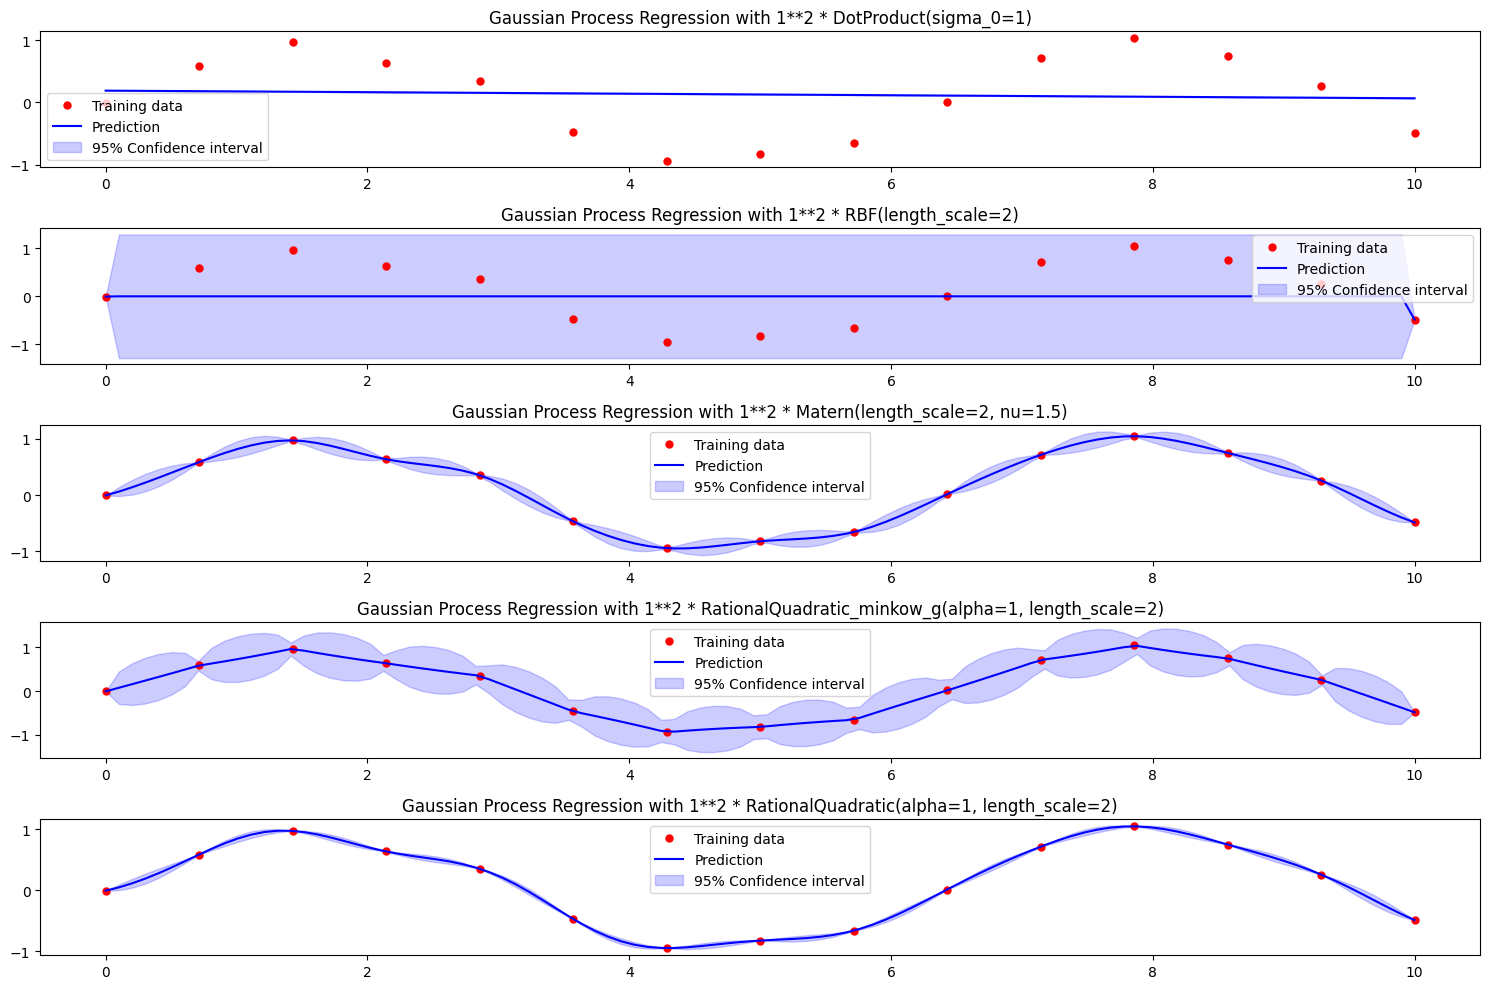

In [9]:
plt.figure(figsize=(15, 10))

# Loop through each kernel
for i, kernel in enumerate(kernels):
    # Create Gaussian Process model
    gp = GaussianProcessRegressor(kernel=kernel)
    
    # Fit to training data
    gp.fit(X_train, y_train)
    
    # Make predictions
    y_pred, sigma = gp.predict(X_test, return_std=True)
    
    # Plot the results
    plt.subplot(len(kernels), 1, i + 1)
    plt.plot(X_train, y_train, 'r.', markersize=10, label='Training data')
    plt.plot(X_test, y_pred, 'b-', label='Prediction')
    plt.fill_between(X_test.ravel(), y_pred - 1.96 * sigma, y_pred + 1.96 * sigma,
                     alpha=0.2, color='blue', label='95% Confidence interval')
    plt.title(f'Gaussian Process Regression with {kernel}')
    plt.legend()

plt.tight_layout()
plt.show()

Kernel: 1**2 * RBF(length_scale=0.5), Log Marginal Likelihood: -4.53
Kernel: 1**2 * RBF(length_scale=2), Log Marginal Likelihood: -15.65
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
Kernel: 1**2 * RationalQuadratic_minkow_g(alpha=1, length_scale=0.5), Log Marginal Likelihood: -9.83
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
Kernel: 1**2 * RationalQu

/home/u/pgpt/privateGPT/pgpt/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/u/pgpt/privateGPT/pgpt/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/u/pgpt/privateGPT/pgpt/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


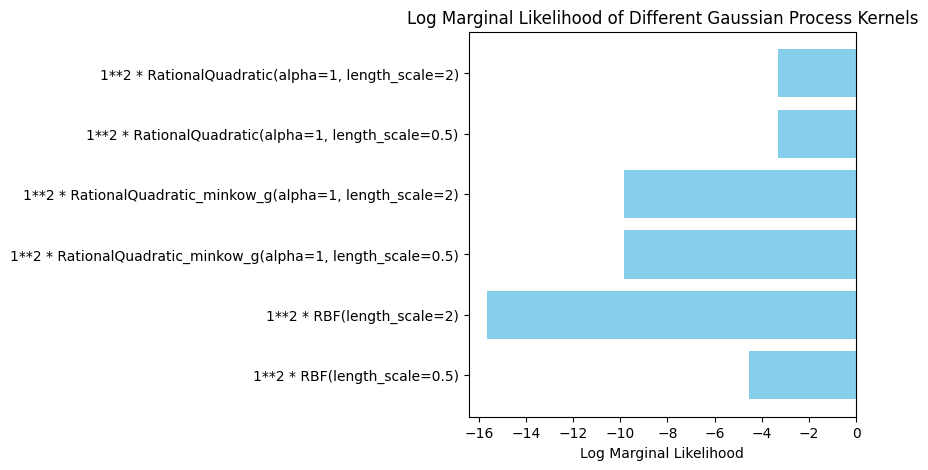

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, RationalQuadratic, ConstantKernel as C

# Create synthetic data
def f(x):
    return np.sin(x) + 0.1 * np.random.randn(*x.shape)

# Generate training data
X_train = np.linspace(0, 10, 15).reshape(-1, 1)
y_train = f(X_train)

# List of kernels to test
kernels = [
    #C(1.0) * DotProduct(),
    C(1.0) * RBF(length_scale=0.5),  # RBF Kernel (smooth)
    C(1.0) * RBF(length_scale=2.0),  # RBF Kernel (less smooth)
    #C(1.0) * Matern(length_scale=1.0, nu=1.5),  # Matern Kernel (smooth)
    #C(1.0) * Matern(length_scale=1.0, nu=0.5),  # Matern Kernel (less smooth)
    #C(1.0) * Matern(length_scale=2.0, nu=0.5),  # Matern Kernel
    C(1.0) * RationalQuadratic_minkow_g(length_scale=0.5,alpha=1) ,
    #C(1.0) * RationalQuadratic_minkow_g(length_scale=1,alpha=1) ,
    C(1.0) * RationalQuadratic_minkow_g(length_scale=2,alpha=1) ,
    #C(1.0) * RationalQuadratic_minkow_g(length_scale=5,alpha=1) ,
    C(1.0) * RationalQuadratic(length_scale=0.5, alpha=1.0), # Rati，onal Quadratic Kernel
    C(1.0) * RationalQuadratic(length_scale=2.0, alpha=1.0), # Rational Quadratic Kernel
    #C(1.0) * RationalQuadratic(length_scale=5.0, alpha=1.0) 
]
# Store log marginal likelihood for each kernel
log_marginal_likelihoods = []
plt.figure(figsize=(5,5))
# Loop through each kernel
for kernel in kernels:
    # Create Gaussian Process model
    gp = GaussianProcessRegressor(kernel=kernel)
    
    # Fit to training data
    gp.fit(X_train, y_train)
    
    # Calculate log marginal likelihood
    log_marginal_likelihood = gp.log_marginal_likelihood(gp.kernel_.theta)
    log_marginal_likelihoods.append(log_marginal_likelihood)
    print(f"Kernel: {kernel}, Log Marginal Likelihood: {log_marginal_likelihood:.2f}")

# Plot log marginal likelihoods
kernel_names = [str(kernel) for kernel in kernels]
plt.barh(kernel_names, log_marginal_likelihoods, color='skyblue')
plt.xlabel('Log Marginal Likelihood')
plt.title('Log Marginal Likelihood of Different Gaussian Process Kernels')
plt.savefig("gaussian_log_margin.eps")
plt.show()